## CREDIT CARD FRAUD DETECTION

We will train an Autoencoder neural network in unsupervised fashion for anomaly detection in credit card transaction data.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid' , palette = 'muted', font_scale = 1.5)

rcParams['figure.figsize'] = 14,8

RANDOM_SEED =42
LABELS = ['Normal', 'Fraud']


## Loading the data

The dataset contains data about credit card transaction that occurred during a period of two days, with 177 frauds out of 71396 transactions. All variables in the dataset are numerical. The data has been transformed using PCA transformations due to privacy reasons.The two features that haven't been changed are time and amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset

In [2]:
data = pd.read_csv('creditcard[2].csv')

In [3]:
data.shape

(71396, 31)

In [4]:
data.isnull().values.any()

True

In [5]:
data_missing = data.isnull().any(axis =1)

In [6]:
data_missing

0        False
1        False
2        False
3        False
4        False
         ...  
71391    False
71392    False
71393    False
71394    False
71395     True
Length: 71396, dtype: bool

In [8]:
data = data.drop(index = 71395)

In [9]:
 data.isnull().values.any()

False

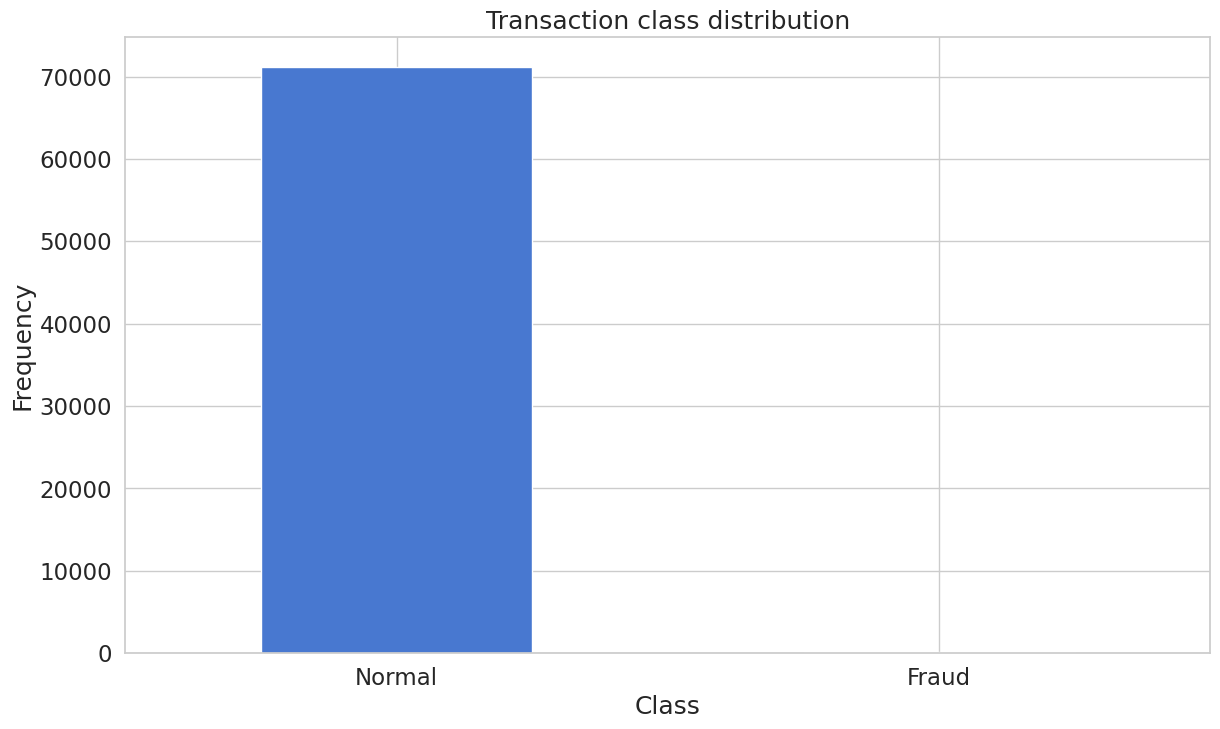

In [10]:
count_classes = pd.value_counts(data['Class'],sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title('Transaction class distribution')
plt.xticks(range(2), LABELS)
plt.xlabel('Class')
plt.ylabel('Frequency');

We have a highly imbalanced dataset on our hands.Normal transactions overwhelm the fradulent ones by a alrge margin.

In [11]:
frauds = data[data.Class == 1]
normal = data[data.Class == 0]

In [12]:
frauds.shape

(177, 31)

In [13]:
normal.shape

(71217, 31)

In [14]:
frauds.Amount.describe()

count     177.000000
mean       95.719153
std       219.167165
min         0.000000
25%         1.000000
50%         7.610000
75%        99.990000
max      1809.680000
Name: Amount, dtype: float64

In [15]:
normal.Amount.describe()

count    71217.000000
mean        97.030101
std        270.412308
min          0.000000
25%          7.680000
50%         26.550000
75%         88.500000
max      19656.530000
Name: Amount, dtype: float64

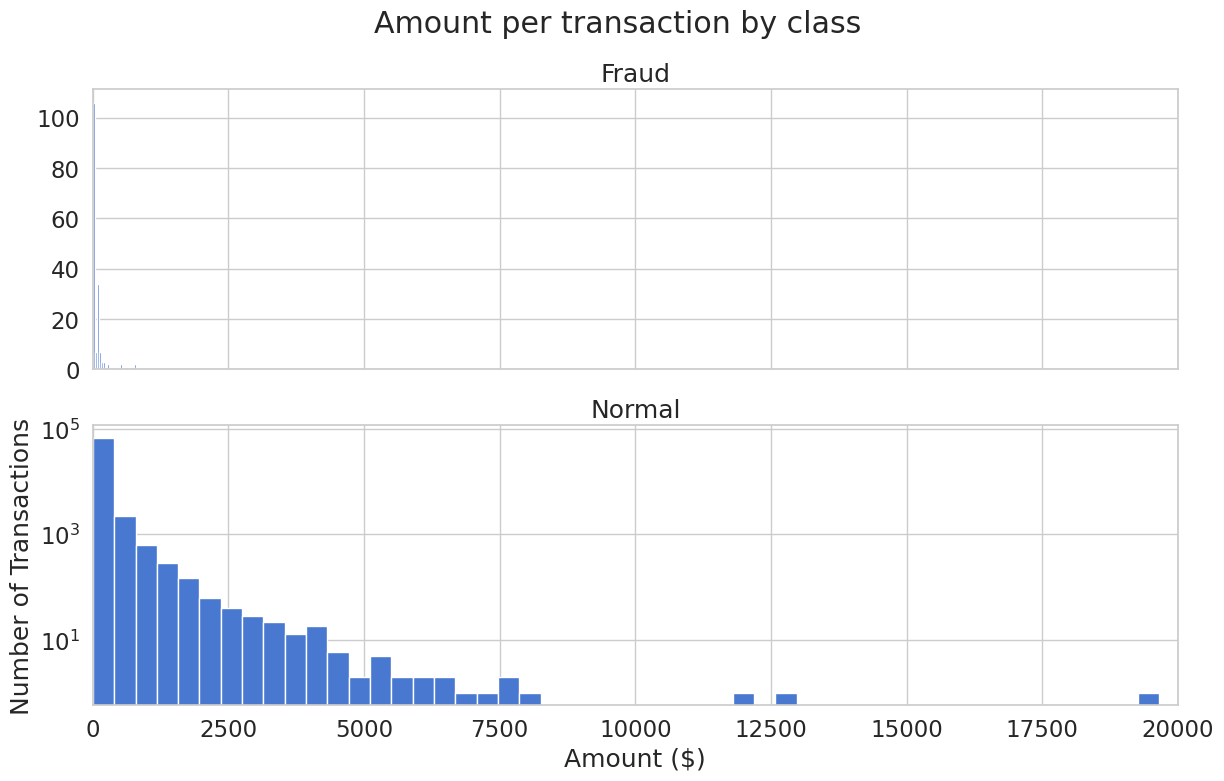

In [16]:
f,(ax1,ax2) = plt.subplots(2,1,sharex = True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins =bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0,20000))
plt.yscale('log')
plt.show();

Do fraudulent transactions occur more often during certain time?

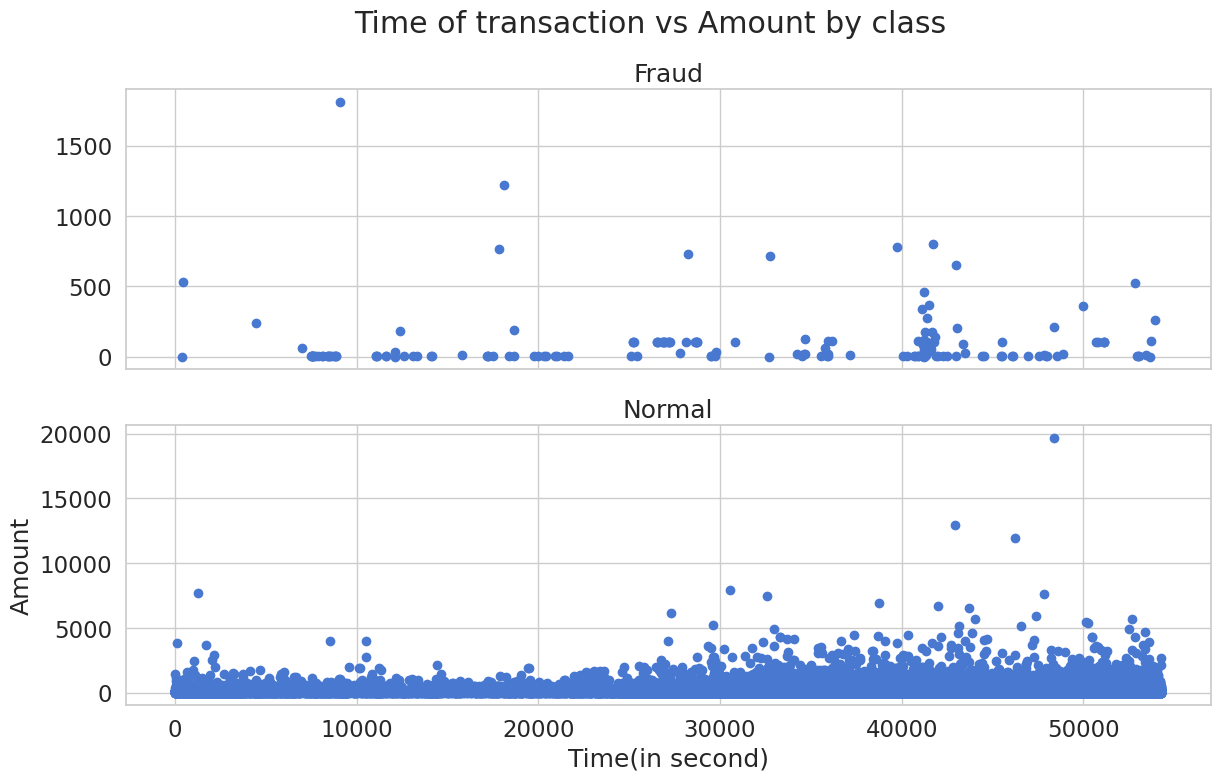

In [17]:
f,(ax1,ax2) = plt.subplots(2,1,sharex = True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time(in second)')
plt.ylabel('Amount')
plt.show()

*Doesn*'t seem like the time of transaction really matter

## Preparing the data

In [18]:
from sklearn.preprocessing import StandardScaler

Data = data.drop(['Time'],axis =1)

Data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

In [19]:
X_train, X_test = train_test_split(Data,test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis =1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'],axis = 1)

X_train = X_train.values
X_test = X_test.values

In [20]:
X_train.shape

(56972, 29)

## Building the Model

In [21]:
input_dim = X_train.shape[1]
encoding_dim = 14


In [22]:
input_layer =Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation='tanh',
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim/2), activation='relu')(encoder)
decoder = Dense(int(encoding_dim/2), activation = 'tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)


In [23]:
nb_epoch = 100
batch_size =32

autoencoder.compile(optimizer = 'adam',
                    loss = 'mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath = 'model.h5',
                               verbose=0,
                               save_best_only = True)
tensorboard = TensorBoard(log_dir ='./logs',
                           histogram_freq = 0,
                           write_graph = True,
                           write_images = True)

history = autoencoder.fit(X_train, X_train,
                           epochs=nb_epoch,
                           batch_size=batch_size,
                           shuffle=True,
                           validation_data=(X_test, X_test),
                           verbose=1,
                           callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
1781/1781 [==============================] - 4s 2ms/step - loss: 0.8811 - accuracy: 0.4110 - val_loss: 1.0071 - val_accuracy: 0.5088
Epoch 2/100
 127/1781 [=>............................] - ETA: 2s - loss: 0.9210 - accuracy: 0.5044

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1781/1781 [==============================] - 3s 2ms/step - loss: 0.7951 - accuracy: 0.5277 - val_loss: 0.9544 - val_accuracy: 0.5486
Epoch 3/100
1781/1781 [==============================] - 3s 2ms/step - loss: 0.7598 - accuracy: 0.5593 - val_loss: 0.9225 - val_accuracy: 0.5676
Epoch 4/100
1781/1781 [==============================] - 3s 2ms/step - loss: 0.7364 - accuracy: 0.5841 - val_loss: 0.9050 - val_accuracy: 0.6038
Epoch 5/100
1781/1781 [==============================] - 5s 3ms/step - loss: 0.7241 - accuracy: 0.6116 - val_loss: 0.8955 - val_accuracy: 0.6257
Epoch 6/100
1781/1781 [==============================] - 4s 2ms/step - loss: 0.7160 - accuracy: 0.6349 - val_loss: 0.8858 - val_accuracy: 0.6419
Epoch 7/100
1781/1781 [==============================] - 4s 2ms/step - loss: 0.7104 - accuracy: 0.6505 - val_loss: 0.8793 - val_accuracy: 0.6562
Epoch 8/100
1781/1781 [==============================] - 4s 2ms/step - loss: 0.7060 - accuracy: 0.6624 - val_loss: 0.8754 - val_accuracy: 0.66

In [25]:
autoencoder = load_model('model.h5')

## Evaluation

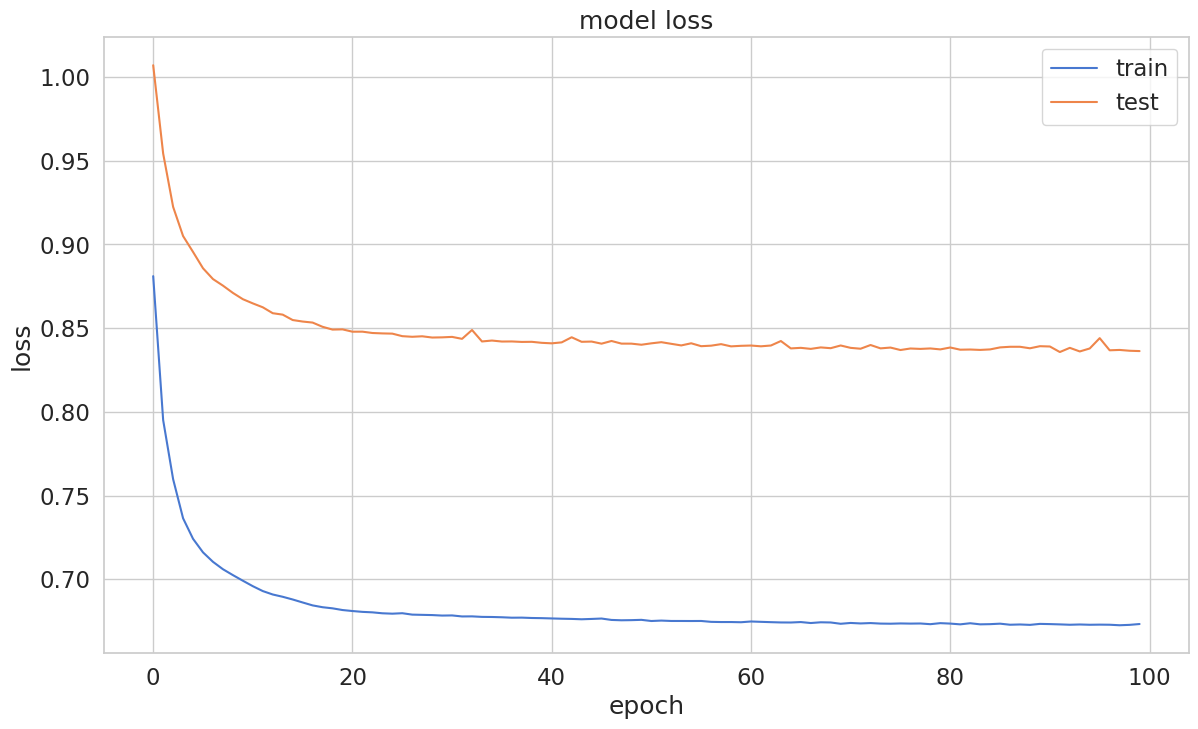

In [26]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [27]:
predictions = autoencoder.predict(X_test)

447/447 [==============================] - 0s 764us/step


In [28]:
mse = np.mean(np.power(X_test - predictions, 2), axis =1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class' : y_test})

In [29]:
error_df.describe()

,reconstruction_error,true_class
count,14279.000000,14279.000000
mean,0.834841,0.002381
std,6.473501,0.048740
min,0.033902,0.000000
25%,0.202868,0.000000
50%,0.348249,0.000000
75%,0.583177,0.000000
max,429.871410,1.000000


## Reconstruction error without fraud

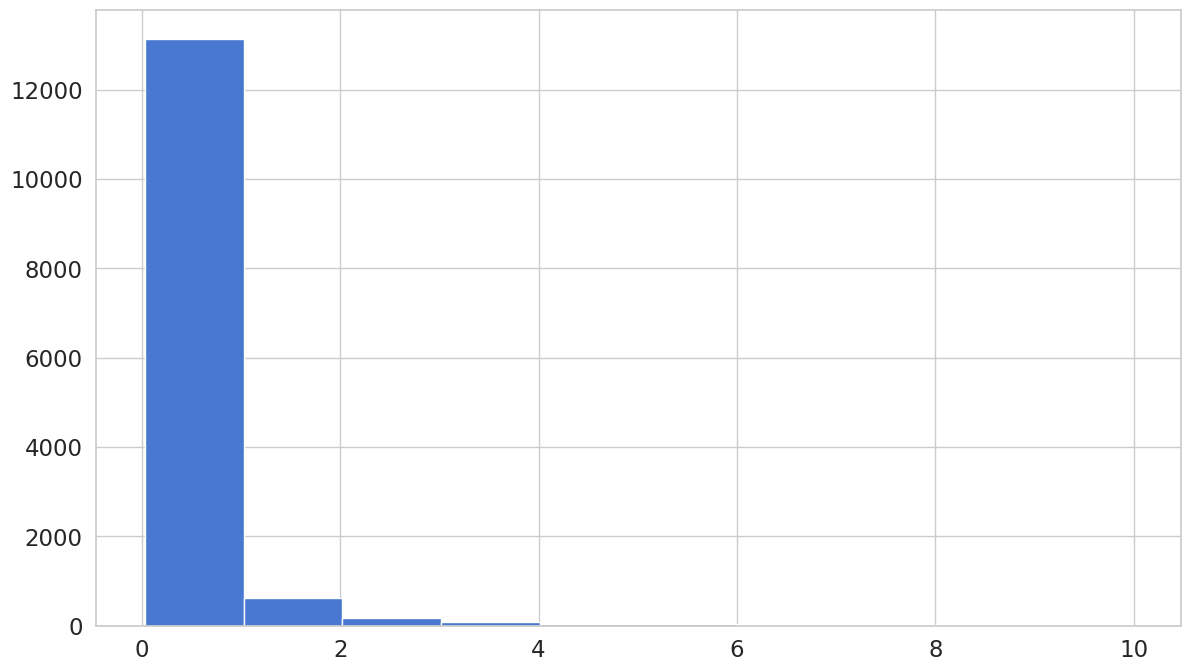

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']==0) & (error_df['reconstruction_error']<10 )]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins =10)

## Reconstruction error with fraud


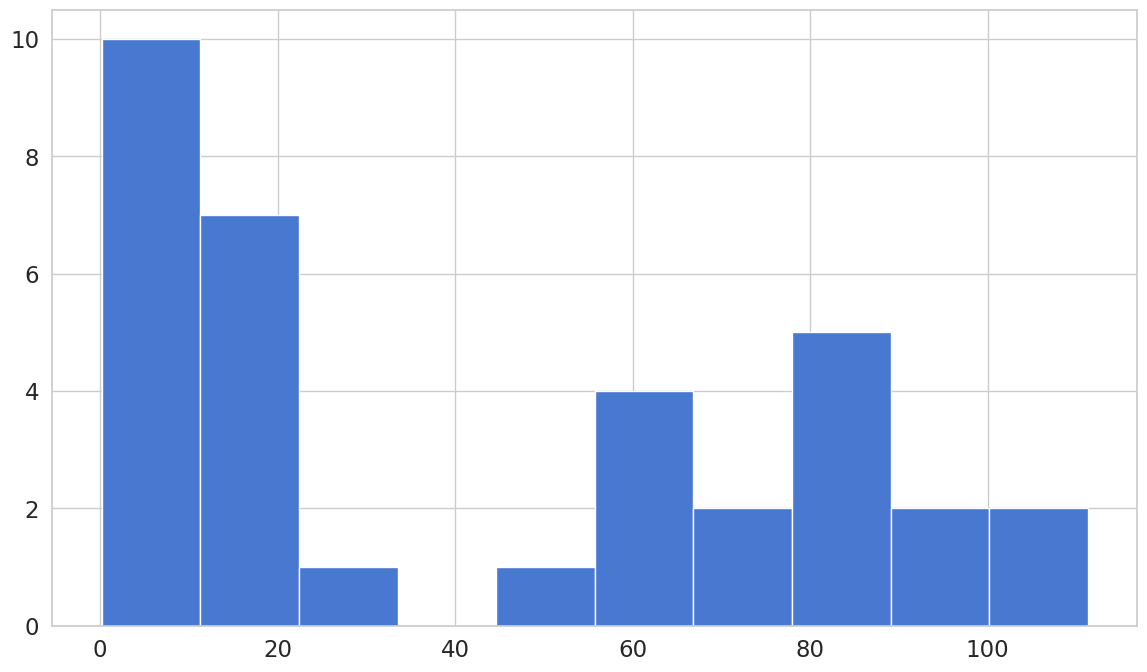

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins = 10)

In [32]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

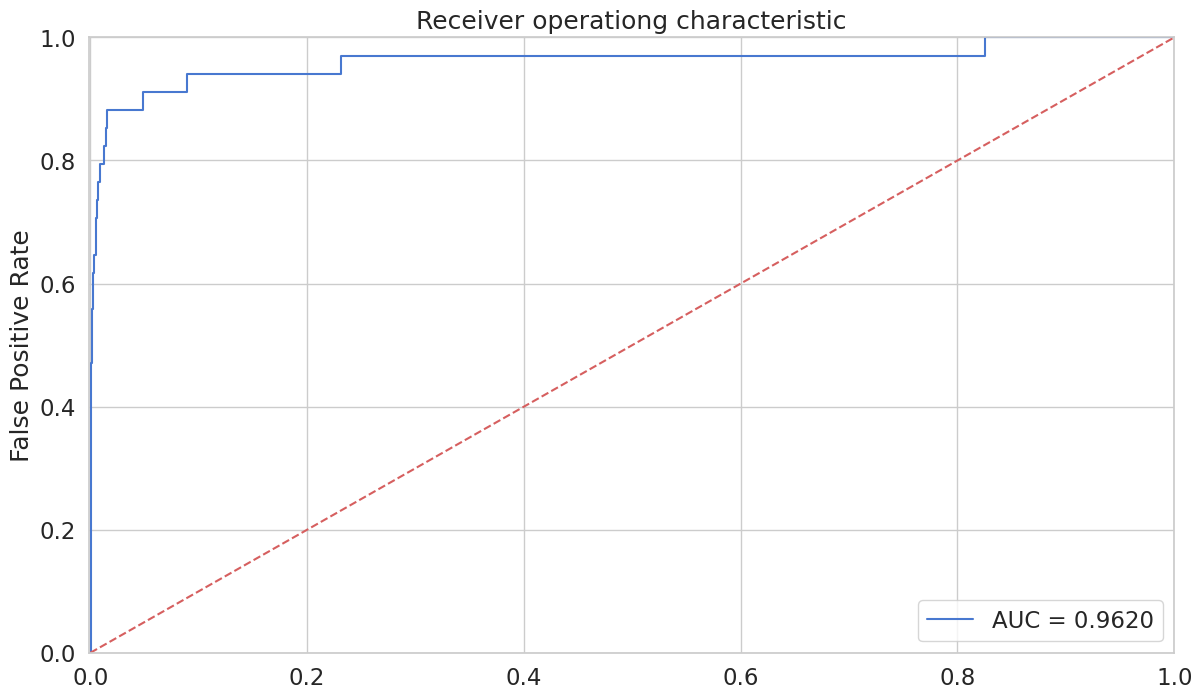

In [35]:
fpr , tpr ,threshholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver operationg characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.show();

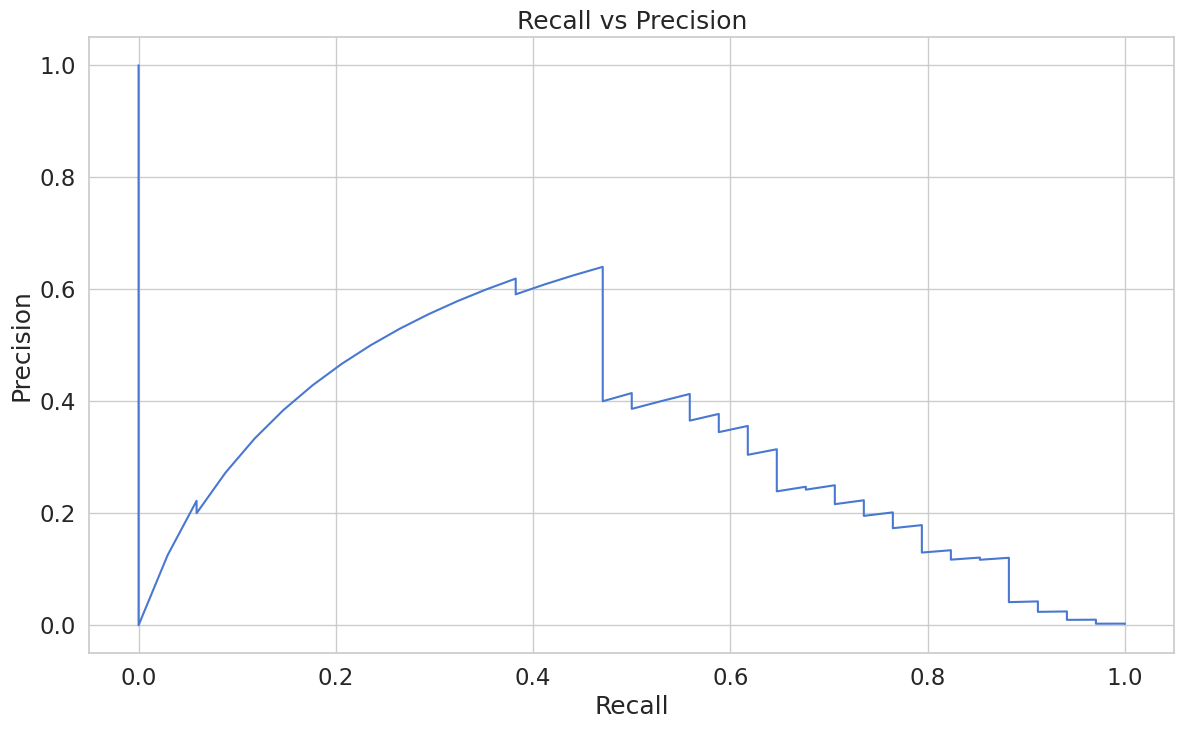

In [36]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b' , label = 'Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates tp a low false positive rate ,and high recall relates to a low false negative rate.High scores for both shiw that the classifier is returning accurate results(high precision) as well as returning a majority of all positive results(high recall).

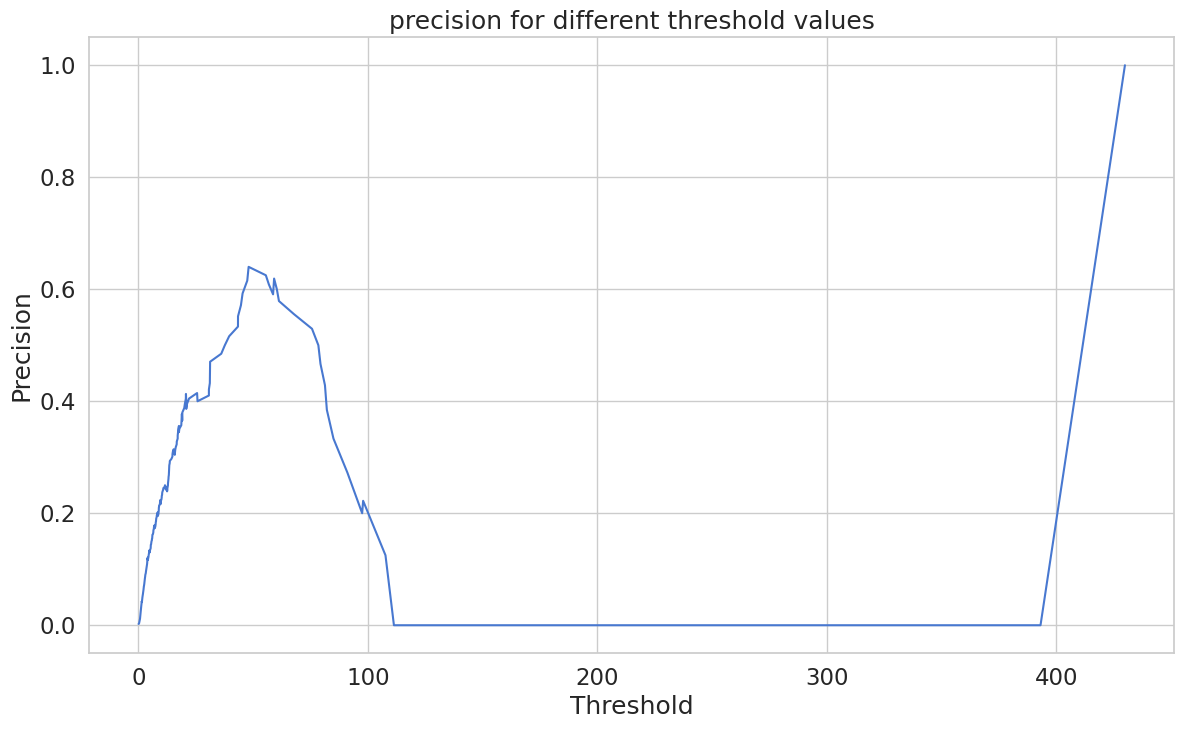

In [37]:
plt.plot(th, precision[1:], 'b', label = 'Threshhold-precision curve')
plt.title('precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

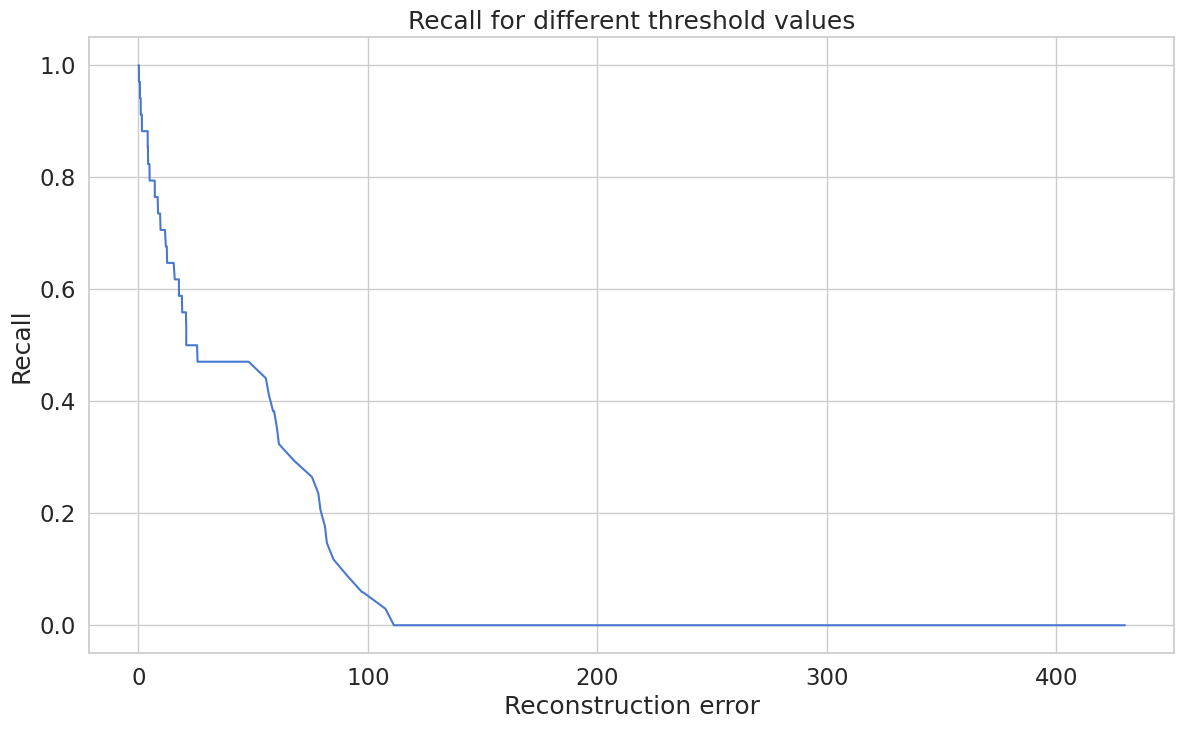

In [38]:
plt.plot(th, recall[1:], 'b' , label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

## Prediction

In [39]:
threshold = 2.9

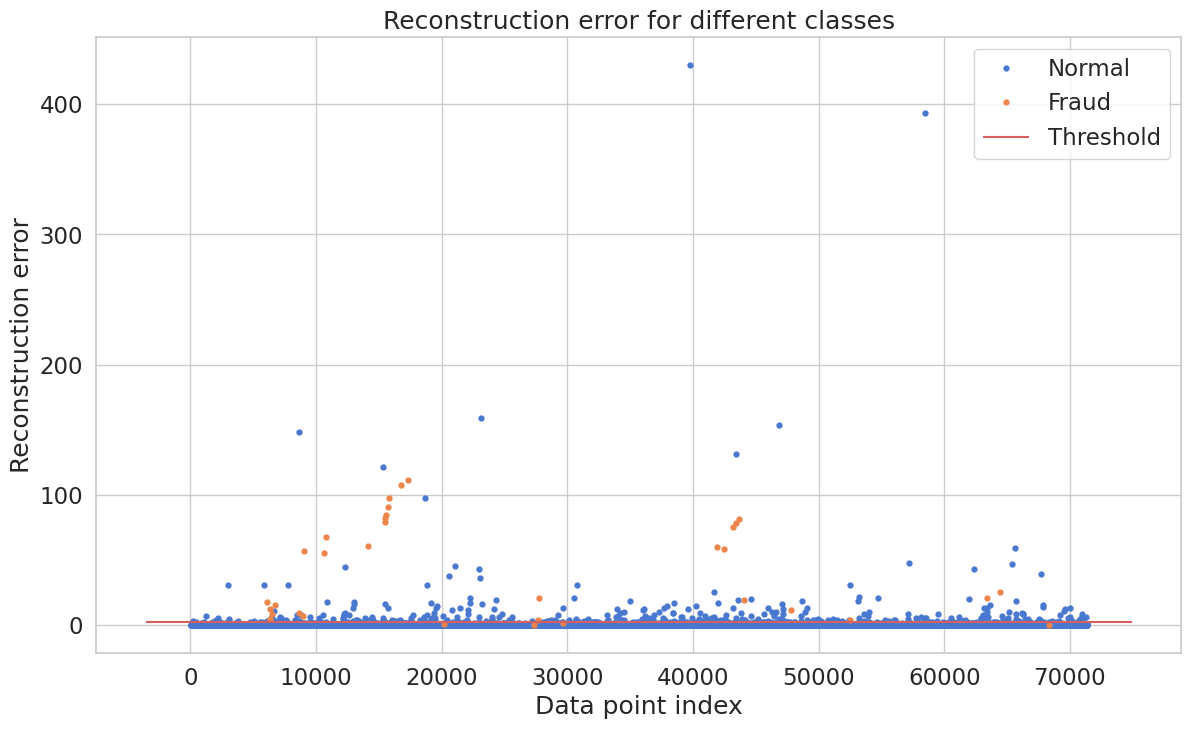

In [44]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker ='o', ms = 3.5, linestyle='',
           label= 'Fraud' if name == 1 else 'Normal')

ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors='r', zorder =100, label ='Threshold')
ax.legend()
plt.title('Reconstruction error for different classes')
plt.ylabel('Reconstruction error')
plt.xlabel('Data point index')
plt.show()

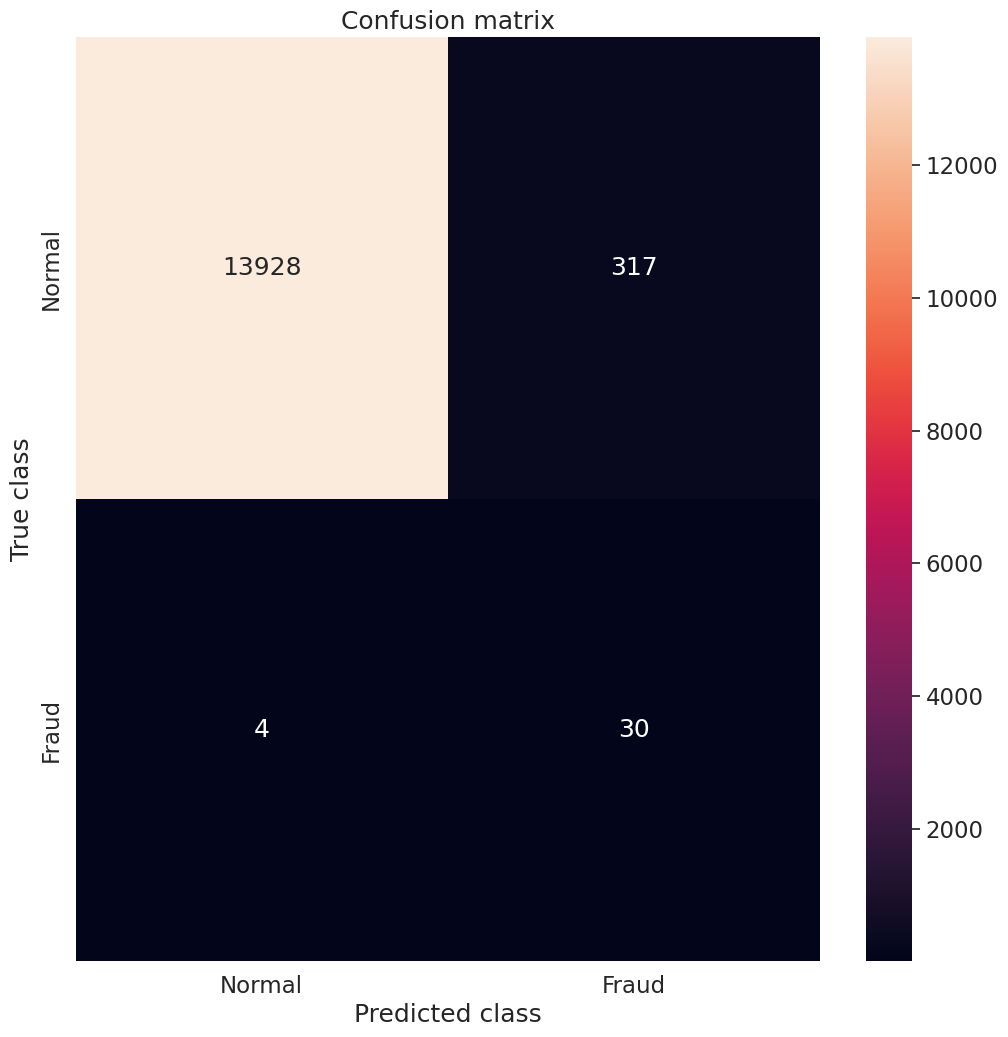

In [45]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt ='d');
plt.title('Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()